In [1]:
import cv2
import numpy as np
import time
import scipy.ndimage.filters as fi
import matplotlib.pyplot as plt
from math import exp
import torch
import torch.nn as nn
import torch.nn.functional as fn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [55]:
def save(model, i=None, name=None):
    i = i or 0
    name = name or type(model).__name__ + str(i)
    torch.save(model.state_dict(), 'dat/' + name + '.pth')

def load(model, i=None, name=None):
    i = i or 0
    name = name or type(model).__name__ + str(i)
    model.load_state_dict(torch.load('dat/' + name + '.pth'))

In [41]:
"""
mostly unmodified from https://github.com/jorge-pessoa/pytorch-msssim

Creates a net that represents the function of SSIM.
It is differentiable to make torch calculate backpropagation implicitly.
"""
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 5:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = fn.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = fn.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = fn.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = fn.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = fn.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = v1 / v2  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        cs = cs.mean()
        ret = ssim_map.mean()
    else:
        cs = cs.mean(1).mean(1).mean(1)
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret

# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size).to(device)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        return ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average, val_range=self.val_range)


In [4]:
class FrameDataset(Dataset):
    def __init__(self, img_dir, n, transform=None, target_transform=None):
        self.img_dir = img_dir.rstrip('/').rstrip('\\')
        self.n = n
        with open(self.img_dir + '/control.dat', "r") as f:
            self.frame_map = np.array(f.read().split(' '), dtype='int32')
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return min(self.n-2, len(self.frame_map))

    def __getitem__(self, idx):
        img_path = self.img_dir + '/frame%d.jpg'
        idx = self.frame_map[idx]
        im1 = cv2.imread(img_path % idx)
        label = cv2.imread(img_path % (idx+1))
        im2 = cv2.imread(img_path % (idx+2))
        if self.transform:
            im1 = self.transform(im1)
            im2 = self.transform(im2)
        if self.target_transform:
            label = self.target_transform(label)
        image = [im1,im2]
        return torch.Tensor(np.array(image)), torch.Tensor(np.array([label]))

In [5]:
class ConvNet(nn.Module):
    def __init__(self, input_shape):
        super().__init__()
        channels = input_shape[2]
        self.main = nn.Sequential(
            nn.Conv2d(channels, 8, (7,7), padding='same', bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 8, (7,7), padding='same', bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 8, (7,7), padding='same', bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(8, 32, (3,3), padding='same', bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(32, channels//2, (3,3), padding='same'))
    def forward(self, x):
        return self.main(x)

In [29]:
def puppy(im):
    return im[:,:,0]/128 - 1

training_data = FrameDataset('dat/part0/',2016, puppy, puppy)
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)

In [30]:
model = ConvNet((360,360,2)).to(device)

In [36]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, betas=(0.5, 0.999))
#training_loss = []

In [37]:
model.train()
for epoch in range(5):

    running_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if i % 10 == 0:
            print('[%d, %5d] loss: %.4f' % (epoch + 1, i + 1, loss.item()))
        training_loss.append(loss.item()/len(inputs))

save(model)
print('Finished Training')

[1,     1] loss: 0.0231
[1,    11] loss: 0.0365
[1,    21] loss: 0.0256
[1,    31] loss: 0.0259
[1,    41] loss: 0.0297
[1,    51] loss: 0.0286
[1,    61] loss: 0.0224
[2,     1] loss: 0.0269
[2,    11] loss: 0.0315
[2,    21] loss: 0.0271
[2,    31] loss: 0.0308
[2,    41] loss: 0.0353
[2,    51] loss: 0.0223
[2,    61] loss: 0.0288
[3,     1] loss: 0.0305
[3,    11] loss: 0.0309
[3,    21] loss: 0.0245
[3,    31] loss: 0.0220
[3,    41] loss: 0.0249
[3,    51] loss: 0.0310
[3,    61] loss: 0.0304
[4,     1] loss: 0.0215
[4,    11] loss: 0.0243
[4,    21] loss: 0.0285
[4,    31] loss: 0.0319
[4,    41] loss: 0.0257
[4,    51] loss: 0.0213
[4,    61] loss: 0.0306
[5,     1] loss: 0.0249
[5,    11] loss: 0.0418
[5,    21] loss: 0.0276
[5,    31] loss: 0.0233
[5,    41] loss: 0.0282
[5,    51] loss: 0.0159
[5,    61] loss: 0.0291
Finished Training


630


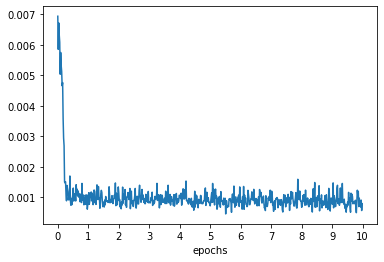

In [39]:
plt.plot(training_loss)
print(len(training_loss))
plt.xticks(np.arange(0,631,63),np.arange(11))
plt.xlabel('epochs')
plt.show()

In [46]:
model = ConvNet((360,360,2)).to(device)

In [51]:
criterion = nn.L1Loss()
modelSSIM = SSIM(size_average=False, val_range=2)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001, betas=(0.5, 0.999))
#training_lossS = []

In [52]:
model.train()
for epoch in range(5):

    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        sims = modelSSIM(labels, outputs)
        loss = criterion(sims, torch.full_like(sims, 1))
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, loss.item()))
        training_lossS.append(loss.item())
        
save(model, name='ConvNetSSIM')
print('Finished Training')

[1,     1] loss: 0.198
[1,    11] loss: 0.169
[1,    21] loss: 0.160
[1,    31] loss: 0.141
[1,    41] loss: 0.146
[1,    51] loss: 0.191
[1,    61] loss: 0.155
[2,     1] loss: 0.151
[2,    11] loss: 0.148
[2,    21] loss: 0.139
[2,    31] loss: 0.146
[2,    41] loss: 0.174
[2,    51] loss: 0.182
[2,    61] loss: 0.135
[3,     1] loss: 0.166
[3,    11] loss: 0.151
[3,    21] loss: 0.156
[3,    31] loss: 0.131
[3,    41] loss: 0.173
[3,    51] loss: 0.145
[3,    61] loss: 0.132
[4,     1] loss: 0.159
[4,    11] loss: 0.132
[4,    21] loss: 0.142
[4,    31] loss: 0.145
[4,    41] loss: 0.169
[4,    51] loss: 0.137
[4,    61] loss: 0.179
[5,     1] loss: 0.166
[5,    11] loss: 0.157
[5,    21] loss: 0.144
[5,    31] loss: 0.161
[5,    41] loss: 0.143
[5,    51] loss: 0.147
[5,    61] loss: 0.132
Finished Training


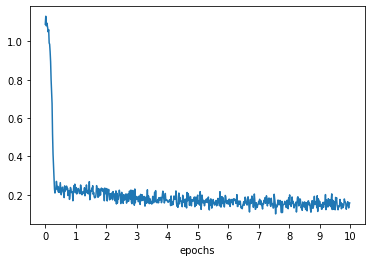

In [53]:
plt.plot(training_lossS)
plt.xticks(np.arange(0,631,63),np.arange(11))
plt.xlabel('epochs')
plt.show()

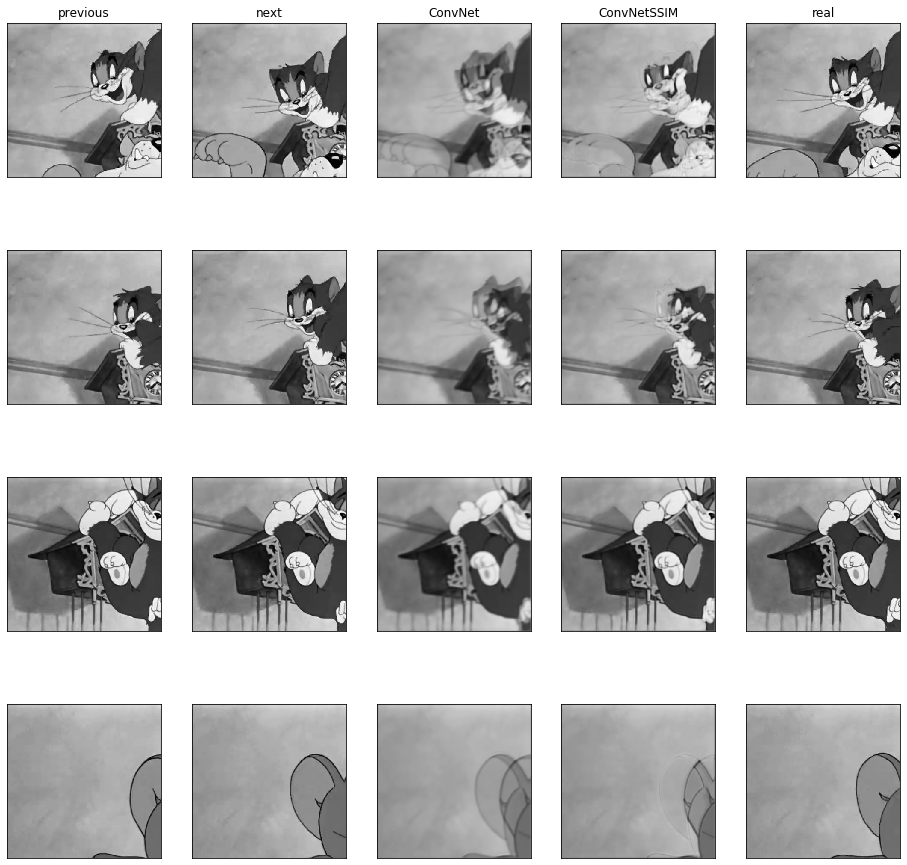

In [56]:
model = ConvNet((360,360,2))
load(model)
model.to(device)

figure, axes = plt.subplots(4,5, figsize=(16,16))
for i in range(4):
    for j in range(5):
        axes[0][j].set_title(['previous','next','ConvNet','ConvNetSSIM','real'][j])
        axes[i][j].tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)

with torch.no_grad():
    n=4
    ins = inputs.cpu().detach()
    outsA = model(inputs).cpu().detach()
    outsB = outputs.cpu().detach()
    mids = labels.cpu().detach()
    for i in range(4):
        axes[i][0].imshow(ins[n*i][0],cmap='gray', vmin=-1, vmax=1)
        axes[i][1].imshow(ins[n*i][1],cmap='gray', vmin=-1, vmax=1)
        axes[i][2].imshow(outsA[n*i][0],cmap='gray', vmin=-1, vmax=1)
        axes[i][3].imshow(outsB[n*i][0],cmap='gray', vmin=-1, vmax=1)
        axes[i][4].imshow(mids[n*i][0],cmap='gray', vmin=-1, vmax=1)

plt.show()